In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from util.ImageFolderWithPaths import ImageFolderWithPaths as IFWP

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd

import sys
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score

from AutoEncoderCNN import AE, Encoder, Decoder

import pickle
from collections import Counter

In [3]:
BATCH_SIZE = 1

# setting the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=0)

# Dataset of both normal and horizontal flipped images
#dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) # + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
#                                                                                                                      tensor_transform,
#                                                                                                                      horizontal_flip
#                                                                                                                    ]))
dataset = IFWP(MAIN_PATH, transform = tensor_transform) 

In [4]:
SPLIT = [55767, 6971, 6971]

train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
enc_out = 8300
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 4096
decoder = Decoder(out_channel = rand_mat_dim)

In [6]:
rand_mat = torch.load('./models/jan_24_25_models/rand_mat.pth')
encoder.load_state_dict(torch.load('./models/jan_24_25_models/encoder.pth'))
decoder.load_state_dict(torch.load('./models/jan_24_25_models/decoder.pth'))

<All keys matched successfully>

In [ ]:
# input and output arrays
encoded_imgs_arr = []
img_arr = []
label_arr = []
patient_arr = []
torch.set_default_device('cuda')

encoder.eval()
decoder.eval()

count = 0
for (inp, label, path) in loader:
    with torch.no_grad():
        inp = inp.to(device)
        p_vec = encoder(inp)@rand_mat
        oup = decoder(p_vec)
        
        # append the p_vec as numpy array, returned as [[]], make into []
        encoded_imgs_arr.append(p_vec.cpu().numpy()[0])
        label_arr.append(label.item())
        patient_arr.append(path[0][51:54])
            
        # doesn't need to be every single img
        if count % 100 == 0:
            img_arr.append(inp.cpu().numpy()[0]) 
        else:
            img_arr.append(None)
            
        if(count % 8000 == 0):
            print(f"{count}/{len(loader)}")
            
        count += 1
            


0/55767
8000/55767
16000/55767
24000/55767
32000/55767
40000/55767
48000/55767


In [ ]:
n_clusters_arr = [i for i in range(2, 10)]

max_dict = {"k": 0, "avg": -2}

for k in n_clusters_arr:
    k_mean = KMeans(n_clusters=k)
    k_labels = k_mean.fit_predict(encoded_imgs_arr)
    
    # https://scikit-learn.org/dev/modules/generated/sklearn.metrics.pairwise.distance_metrics.html
    sil_avg = silhouette_score(encoded_imgs_arr, k_labels, metric="euclidean")
    if max_dict["avg"] < sil_avg:
        max_dict["k"] = k
        max_dict["avg"] = sil_avg
    print(f'{k=}: {sil_avg=}')
    
print(f"{max_dict=}")

In [ ]:
k =  max_dict["k"]
kmeans = KMeans(n_clusters=k)
kmeans.fit(encoded_imgs_arr)
print(f"Sum of squared distance to closest cluster center: {kmeans.inertia_:.10f}")

In [11]:
max_dict

{'k': 5, 'avg': 0.549956}

In [11]:
len(encoded_imgs_arr)

55767

In [12]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_imgs_arr) # fit_transform or fit?

In [8]:
k = 5
kmeans = pickle.load(open("./models/jan_24_25_models/kmeans.pickle", 'rb'))
tsne = pickle.load(open("./models/jan_24_25_models/tsne.pickle", 'rb'))
tsne_results = np.load("./models/jan_24_25_models/tsne_results.npy")
# df = pd.read_csv("./models/jan_24_25_models/df.csv")

In [9]:
# Note: 84 patients
col_names = ["X T-SNE", "Y T-SNE", 
             "True Label", "K-means Grouping", "Color T", "Color K", 
             "Patient", "Img Data"]
df = pd.DataFrame(list(zip(tsne_results[:,0],            # x tsne
                           tsne_results[:,1],            # y tsne
                           label_arr,                    # true label
                           kmeans.labels_,               # k-mean label
                           kmeans.labels_,               # temp for colors
                           kmeans.labels_,               # temp for colors
                           patient_arr,                  # patient number
                           img_arr)),                    # imgs             
                 columns=col_names)

colors = list(mcolors.TABLEAU_COLORS)
for i in range(k):
    df.loc[df["K-means Grouping"] == i, "Color K"] = colors[i]

for i in range(max(label_arr) - min(label_arr) + 1):
    df.loc[df["True Label"] == i, "Color T"] = colors[i]

df.to_csv("./models/jan_24_25_models/df.csv")

In [10]:
df.head()

,X T-SNE,Y T-SNE,True Label,K-means Grouping,Color T,Color K,Patient,Img Data
0,26.799244,1.470017,0,1,tab:blue,tab:orange,023,"[[[0.6666667, 0.73333335, 0.83137256, 0.772549..."
1,2.356114,19.648424,1,0,tab:orange,tab:blue,081,None
2,3.051031,19.545158,1,0,tab:orange,tab:blue,090,None
3,-26.870975,-2.415130,0,2,tab:blue,tab:green,040,None
4,4.777150,26.264458,1,0,tab:orange,tab:blue,079,None


In [11]:
temp0 = Counter(df.loc[df["True Label"] == 0]["K-means Grouping"].values)
temp1 = Counter(df.loc[df["True Label"] == 1]["K-means Grouping"].values)

c0 = {}
p0 = {}
for i in range(k):
    c0[i] = temp0[i]
    p0[i] = int( (temp0[i] / sum(temp0.values())*1000)) /1000
c1 = {}
p1 = {}
diff = {}
for i in range(k):
    c1[i] = temp1[i]
    p1[i] = int( (temp1[i] / sum(temp1.values())*1000)) /1000
    diff[i] = int( (p1[i] - p0[i])*1000) /1000


print(f"Asymptomatic:\t{c0} {p0}\nSymptomatic:\t{c1} {p1}\n\nDiff P(S)-P(A):\t{diff}")

Asymptomatic:	{0: 7233, 1: 7604, 2: 6390, 3: 9892, 4: 2975} {0: 0.212, 1: 0.223, 2: 0.187, 3: 0.29, 4: 0.087}
Symptomatic:	{0: 6285, 1: 3585, 2: 4335, 3: 5556, 4: 1912} {0: 0.289, 1: 0.165, 2: 0.2, 3: 0.256, 4: 0.088}

Diff P(S)-P(A):	{0: 0.076, 1: -0.057, 2: 0.013, 3: -0.033, 4: 0.001}


In [12]:
# create dictionary: d["000"] = {'0': x, '1': ...} 
d = {}
for patient_num, patient_group in df.groupby("Patient"):
    c = Counter(patient_group["K-means Grouping"])
    temp = {}
    for i in range(k):
        try:
            temp[i] = c[i]
        except KeyError:
            temp[i] = 0
    d[patient_num] = temp
d    

{'001': {0: 157, 1: 122, 2: 49, 3: 181, 4: 23},
 '002': {0: 276, 1: 419, 2: 15, 3: 159, 4: 20},
 '004': {0: 136, 1: 211, 2: 24, 3: 362, 4: 70},
 '005': {0: 11, 1: 46, 2: 94, 3: 265, 4: 189},
 '006': {0: 124, 1: 110, 2: 36, 3: 85, 4: 0},
 '007': {0: 119, 1: 78, 2: 2, 3: 36, 4: 1},
 '008': {0: 129, 1: 97, 2: 330, 3: 251, 4: 203},
 '009': {0: 142, 1: 26, 2: 463, 3: 121, 4: 54},
 '010': {0: 59, 1: 26, 2: 49, 3: 134, 4: 151},
 '011': {0: 160, 1: 143, 2: 181, 3: 270, 4: 91},
 '012': {0: 127, 1: 220, 2: 101, 3: 222, 4: 8},
 '013': {0: 19, 1: 4, 2: 392, 3: 45, 4: 105},
 '014': {0: 14, 1: 1, 2: 312, 3: 4, 4: 19},
 '015': {0: 40, 1: 7, 2: 355, 3: 46, 4: 29},
 '016': {0: 49, 1: 19, 2: 439, 3: 108, 4: 148},
 '017': {0: 45, 1: 168, 2: 196, 3: 375, 4: 143},
 '018': {0: 119, 1: 248, 2: 83, 3: 136, 4: 5},
 '019': {0: 157, 1: 448, 2: 43, 3: 483, 4: 50},
 '020': {0: 368, 1: 248, 2: 40, 3: 270, 4: 35},
 '021': {0: 4, 1: 8, 2: 122, 3: 36, 4: 51},
 '022': {0: 210, 1: 353, 2: 59, 3: 406, 4: 42},
 '023': {0:

In [13]:
amt_imgs = 10
k_img_arr = []
t_img_arr = []

# Populate img_arr with 3 items, of amt_imgs imgs per item
# Note the index will be the corresponding k
for k_temp, df_group in df.groupby("K-means Grouping"):
    k_img_arr.append([])
    for img in df_group["Img Data"]:
        if img is not None and str(img) != 'nan':
            k_img_arr[k_temp].append(img)


# Populate img_arr with 2 items, of amt_imgs imgs per item
# Note the index will be the corresponding label
for t_temp, df_group in df.groupby("True Label"):
    t_img_arr.append([])
    for img in df_group["Img Data"]:
        if img is not None:
            t_img_arr[t_temp].append(img)

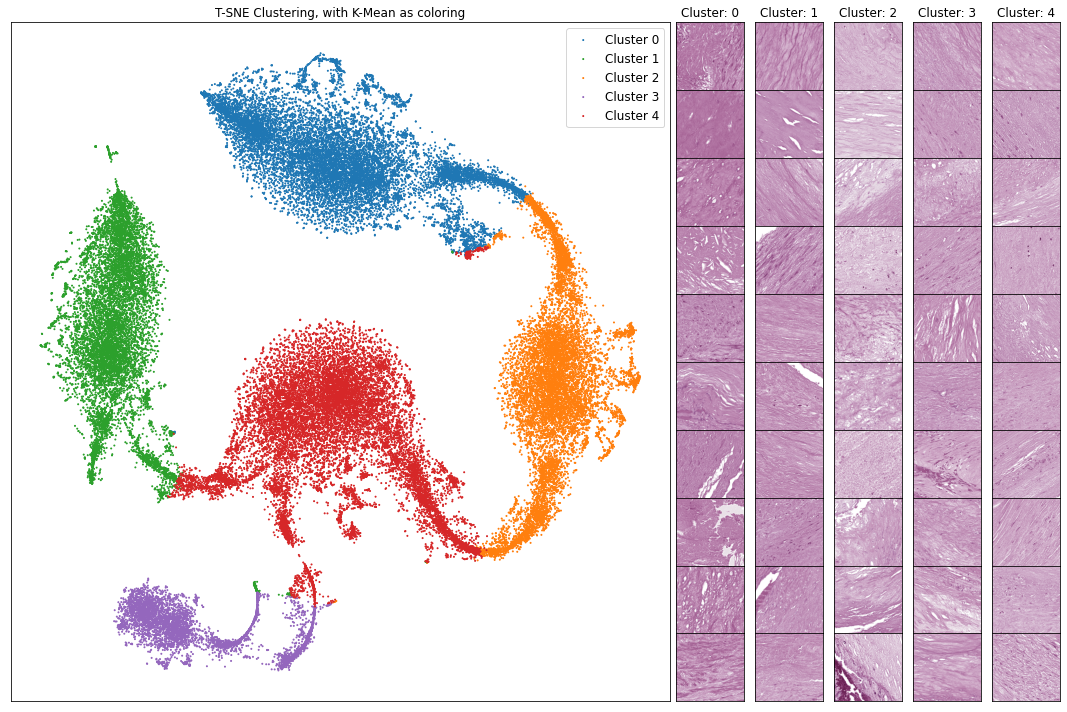

In [14]:
fig = plt.figure(figsize=(15,10))

widths = [0.125] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color K"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color K"], 
                label=f"Feature {color}", s=1)
ax.set_title("T-SNE Clustering, with K-Mean as coloring")
legend_arr = [f"Cluster {i}" for i in range(k)]
plt.legend(legend_arr, prop={'size': 12})

# Loop across cols
for j in range(1, k+1):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Cluster: {j-1}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = k_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()

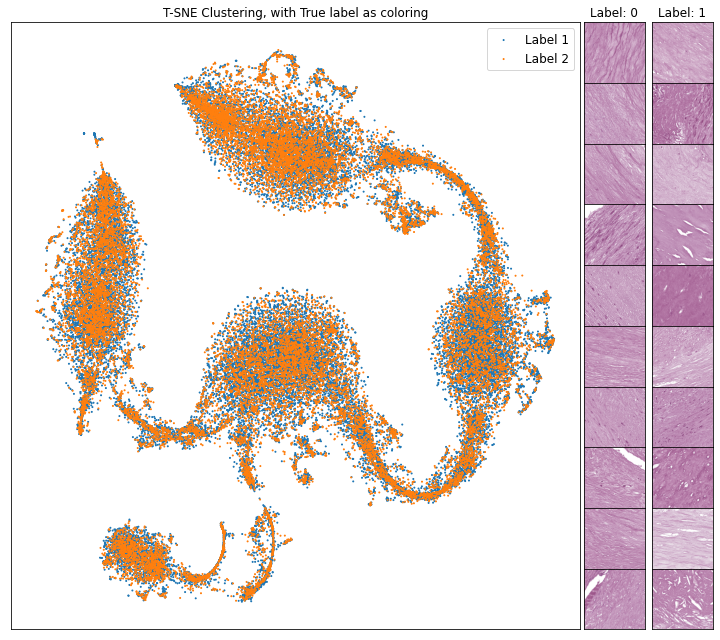

In [15]:
fig = plt.figure(figsize=(13,9))

widths = [0.125] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color T"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color T"], 
                label=f"Feature {color}", s=1)
    
plt.xticks([])  
plt.yticks([])
plt.title("T-SNE Clustering, with True label as coloring")

legend_arr = [f"Label {i+1}" for i in range(max(label_arr) - min(label_arr) +1)]
plt.legend(legend_arr, prop={'size': 12})

# Loop across cols
for j in range(1, 3):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Label: {j-1}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = t_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()

In [70]:
score = adjusted_rand_score(df["True Label"], df["K-means Grouping"])
score

0.004479052204104112

In [77]:
silhouette_score(encoded_imgs_arr, df["K-means Grouping"].values, metric="euclidean")

0.549956

In [29]:
np.save("./models/jan_24_25_models/tsne_results.npy", tsne_results)

In [25]:
pickle.dump(kmeans, open("./models/kmeans.pickle", "wb"))
pickle.dump(tsne, open("./models/tsne.pickle", "wb"))